In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

df = pd.read_csv("../Data/IST_CWPL.csv", sep=";")
df = df[pd.to_numeric(df['Zyklus'], errors='coerce').notnull()] #remove non numeric cycles
df.head()

,SapNummer,Version,WA,CreateDate,MessungsArt,Profilname,AnzahlZyklen,Temperatur,TestEndkriterium,Name,...,WiderstandPower,WiderstandSenseA,WiderstandSenseB,PCWiderstandZielTemp,SCWiderstandZielTemp,SBCWiderstandZielTemp,TestZähler,Maschinennummer,Unnamed: 26,Unnamed: 27
0,453828,B,CWPL,2023-09-15 08:24:27.000,DS,T210_R10_C200,200,210.0,A and B,40_L,...,1528.9,2960.1,2073.7,1526.8,2955.5,2071.4,1,4,NaN,#WERT!
1,453828,B,CWPL,2023-09-15 08:24:27.000,DS,T210_R10_C200,200,210.0,A and B,40_L,...,1530.6,2963.6,2076.4,1526.8,2955.5,2071.4,1,4,NaN,NaN
2,453828,B,CWPL,2023-09-15 08:24:27.000,DS,T210_R10_C200,200,210.0,A and B,40_L,...,1531.4,2963.9,2078.5,1526.8,2955.5,2071.4,1,4,NaN,NaN
3,453828,B,CWPL,2023-09-15 08:24:27.000,DS,T210_R10_C200,200,210.0,A and B,40_L,...,1532.4,2966.6,2078.8,1526.8,2955.5,2071.4,1,4,NaN,NaN
4,453828,B,CWPL,2023-09-15 08:24:27.000,DS,T210_R10_C200,200,210.0,A and B,40_L,...,1533.7,2968.6,2081.9,1526.8,2955.5,2071.4,1,4,NaN,NaN


In [2]:
def get_delta(df,column):
    
    df = df.copy()
    df["mask_first"] = (df["Name"] != df["Name"].shift(periods=1, axis=0) ) #get bool column when a new device starts
    df["ref"] = df[df["mask_first"]][column]                                #place reference in its column
    df["ref"] = df["ref"].ffill()                                           #fill the columns with the reference
    df["delta_"+column] =  (df[column]/df["ref"]-1)*100                     #calculate shift
    df.pop("ref")                                                           
    
    return df

df = get_delta(df,"WiderstandSenseA")
df = get_delta(df,"WiderstandSenseB")

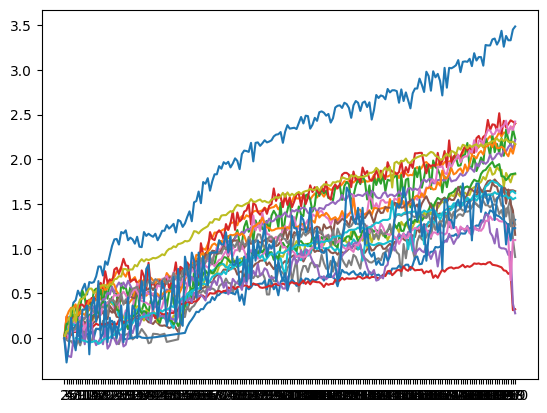

In [3]:
for name in df["Name"].unique():
    
    plt.plot(df[df["Name"] == name]["Zyklus"],df[df["Name"] == name]["delta_WiderstandSenseB"])

# Let's work on one series and try to fit it

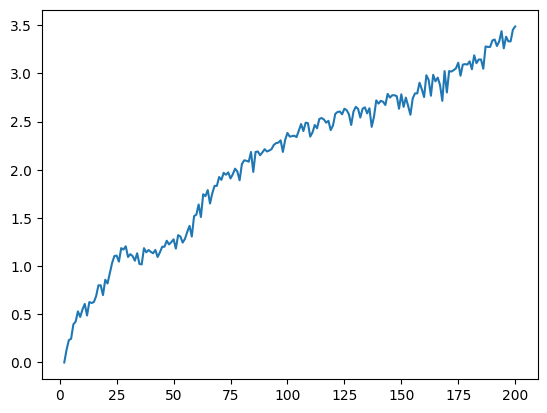

In [31]:
name = "40_L"
df_1 = df[df["Name"] == name]
x = df_1["Zyklus"].astype(float)
y = df_1["delta_WiderstandSenseB"]

plt.plot(x,y)

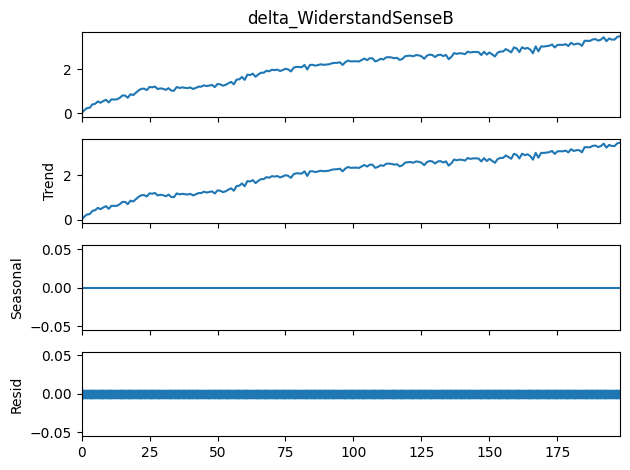

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

series = y
result = seasonal_decompose(series, model='additive', period=1)
result.plot()
plt.show()

### Polynomial fit

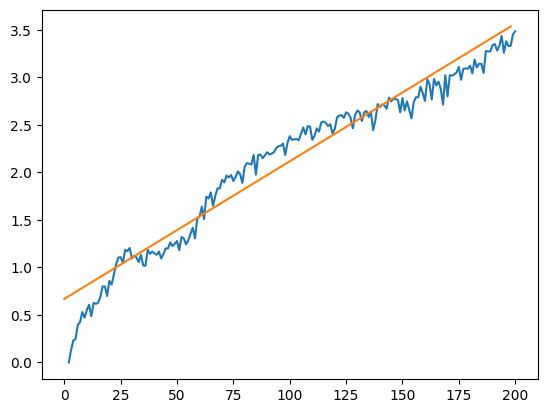

In [36]:
p = np.polyfit(x, y, 1, rcond=None, full=False, w=None, cov=False)
plt.plot(x,y)
plt.plot(p[0]*x+p[1])

In [23]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import HuberLoss, MAE

nf = NeuralForecast(
    models = [NHITS(h=12,
                    input_size=24,
                    #loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
                    loss=HuberLoss(delta=0.5),
                    valid_loss=MAE(),
                    stat_exog_list=['airline1'],
                    scaler_type='robust',
                    max_steps=200,
                    early_stop_patience_steps=2,
                    val_check_steps=10,
                    learning_rate=1e-3)
            ],
    freq = 'M'
)

Seed set to 1


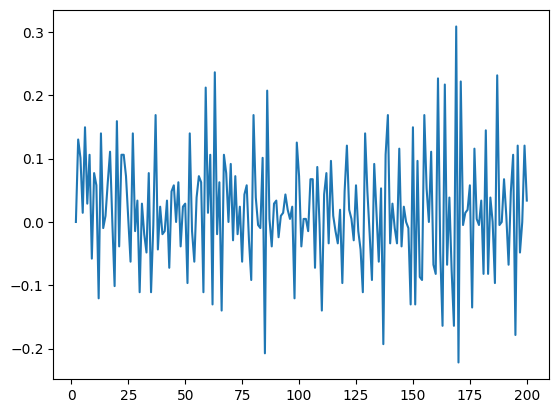

In [12]:
df_sel = df
df_trial = pd.DataFrame({"unique_id" : df[df["Name"] == name]["Name"],
                        "ds"         : df[df["Name"] == name]["Zyklus"].astype(int),
                        "y_raw"          : df[df["Name"] == name]["delta_WiderstandSenseB"]
                        })

df_trial["y"] = df_trial["y_raw"].diff().fillna(0)

plt.plot(df_trial["ds"],df_trial["y"])

In [67]:
h_window = len(df_trial["ds"])-1
horizon = round(0.5*h_window)

nf = NeuralForecast(
    models = [NHITS(h=horizon,
                    input_size=h_window,
                    #loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
                    loss=HuberLoss(delta=0.5),
                    valid_loss=MAE(),
                    #stat_exog_list=['airline1'],
                    #scaler_type='robust',
                    max_steps=100,
                    #early_stop_patience_steps=2,
                    #val_check_steps=10,
                    learning_rate=1e-3)
            ],
    freq = 'M'
)

Seed set to 1


In [68]:
nf.fit(df=df_trial)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [69]:
Y_hat_df = nf.predict()

Predicting: |          | 0/? [00:00<?, ?it/s]

In [70]:
Y_hat_df

,ds,NHITS
unique_id,,
40_L,201,-0.047298
40_L,202,0.001874
40_L,203,0.063515
40_L,204,0.027660
40_L,205,0.042596
...,...,...
40_L,295,0.062112
40_L,296,0.081846
40_L,297,0.178512


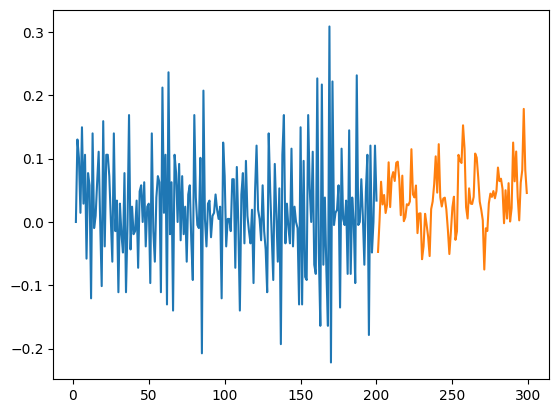

In [74]:
plt.plot(df_trial["ds"],df_trial["y"])
plt.plot(Y_hat_df["ds"],Y_hat_df["NHITS"])

AttributeError: 'NeuralForecast' object has no attribute 'named_parameters'